In [39]:
import os
path = os.path.abspath(os.getcwd())
print(path)
folder = os.path.split(path)[-1]
if folder == 'Subjects_Scripts':
    print('Subjects_Scripts')
    %run my_imports.py
elif folder == 'BREATHING_PROJECT':
    print('BREATHING_PROJECT')
    %run Subjects_Scripts/my_imports.py

C:\Users\bastien\Documents\Git\python_analysis_2\project\BREATHING_PROJECT\Subjects_Scripts
Subjects_Scripts


In [40]:
# folderSubject = r'D:\results\Results_ANS\subjectFolderExperiment\s0'

In [41]:
folderName = os.path.join(folderSubject,'records','fif')
print(folderName)
raws_list,events = load_fif_from_folder(folderName,concatFile=False)

raws = mne.concatenate_raws(raws_list)
events = mne.find_events(raws, stim_channel='TRIGGER', shortest_event = 1)
montageFile = os.path.join(folderAnalysis,'locFile','montageANT64_inverse.txt')
layoutFile  = os.path.join(folderAnalysis,'locFile','antneuro_64ch.lay')
chan_dict_file = os.path.join(folderAnalysis,'locfile','chan_dict_64ANT.txt')

f = open(chan_dict_file,'r')
chan_dict = eval(f.read())
     
cfg= {'spatial_filter': 'CAR',
'montage_file':montageFile,
'layout_file':layoutFile}

scale = dict(mag=1e-12, grad=4e-11, eeg=100, eog=150, ecg=500,
     emg=1e3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1e3, chpi=1e-4, whitened=1e2)


if 'AUX3' in raws.ch_names and 'AUX19' in raws.ch_names:
    print("1")
    resp_chan = "AUX3"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX3':'resp','AUX19':'ecg','M1':'emg','M2':'emg'}
elif 'AUX3' in raws.ch_names and 'AUX13' in raws.ch_names:
    print("2")
    resp_chan = "AUX3"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX3':'resp','AUX13':'ecg','M1':'emg','M2':'emg'}
elif 'AUX3' in raws.ch_names and 'AUX7' in raws.ch_names:
    print("3")
    resp_chan = "AUX3"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX3':'resp','AUX7':'ecg','M1':'emg','M2':'emg'}
elif 'AUX19' in raws.ch_names and 'AUX20' in raws.ch_names:
    print("4")
    resp_chan = "AUX19"
    if 'EOG' in raws.ch_names:
        mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX19':'resp','AUX20':'ecg','M1':'emg','M2':'emg'}
    else:
        mapping_channel_type = {'TRIGGER':'stim','AUX19':'resp','AUX20':'ecg','M1':'emg','M2':'emg'}
        
elif 'AUX3' in raws.ch_names:
    print("5")
    resp_chan = "AUX3"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX3':'resp','M1':'emg','M2':'emg'}
    
raws.set_channel_types(mapping_channel_type)
raws = set_montage_from_file(raws,cfg,kind='topomap')

print('[Preprocessing] Preprocessed Data')

print('[Events Visualization] Checking events')
print(np.unique(events[:,2]))
print('[Events Visualization] Define dictionary for epoching')
    
listEventOfInterest = {'CUE_START_INHALE':43,
                 'CUE_START_EXHALE':44,
                 'CUE_STOP_INHALE':50,
                 'CUE_STOP_EXHALE':51}

# Clean channel names to be able to use a standard 1005 montage
new_names = dict(
    (ch_name,
     ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
    for ch_name in raws.ch_names)
raws.rename_channels(new_names)

D:\results\Results_ANS\subjectFolderExperiment\s0\records\fif
[Load Data] Found 6 files
5
[Preprocessing] Preprocessed Data
[Events Visualization] Checking events
[10 20 30 40 43 44 50 51 55 70]
[Events Visualization] Define dictionary for epoching


# Independent Component Analysis

In [47]:
from mne.preprocessing import ICA
method = 'fastica'

# Choose other parameters
n_components = 61  # if float, select n_components by explained variance of PCA
decim = 3  # we need sufficient statistics, not all time points -> saves time

# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 23
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

# Apply Temporal Filtering
picks_eeg = mne.pick_types(raws.info,eeg=True)
raws_filtered = raws.copy()
raws_filtered = raws_filtered.pick(picks_eeg)
raws_filtered.filter(l_freq =1,h_freq = 40)
print('[Preprocessing] Temporal Filtering applied on data (Step 1/3)')

listEventOfInterest = {'MI_START':40}
epochs  = mne.Epochs(raws_filtered, events, event_id=listEventOfInterest,
                         tmin=-8, tmax=6,baseline=None, preload = True)
ica.fit(epochs, picks='eeg', decim=decim)
print(ica)

<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>
[Preprocessing] Temporal Filtering applied on data (Step 1/3)
<ICA  |  epochs decomposition, fit (fastica): 95600 samples, 61 components, channels used: "eeg">


In [32]:
ica.exclude.extend([0,1])
raws_ICA = ica.apply(raws_filtered)
print('[Preprocessing] Apply ICA on data (Step 2/3)')

[Preprocessing] Apply ICA on data (Step 2/3)


# Preprocessing

In [33]:
# Apply Spatial Filtering
picks_eeg = mne.pick_types(raws.info,eeg=True)
raws_preprocessed = raws_ICA.copy()
# raws_preprocessed = raws_preprocessed.pick(picks_eeg)
raws_ERDS  = apply_spatial_filter(raws_preprocessed,spatial_filer='CAR')
print('[Preprocessing] Spatial Filtering applied on data (Step 2/3)')

[Preprocessing] Spatial Filtering applied on data (Step 2/3)


# ERDS Phase Coupling 

In [34]:
listEventOfInterest = {'HOLD':40,'MI_START':40,
                'MI_STOP':55}

# Amplitude
raw_filter = raws.copy()
picks_RESP = raw_filter.ch_names.index(resp_chan)
resp_data = np.squeeze(raw_filter.get_data(picks=picks_RESP))
sfreq = raw_filter.info['sfreq']
transient_change = mne.filter.filter_data(resp_data,sfreq=sfreq,l_freq=0.1,h_freq=10)
transient_change = np.reshape(transient_change, (-1, 1)).T 
info = mne.create_info(['AUX3filter'], raws.info['sfreq'], ['ecg'])
stim_raw = mne.io.RawArray(transient_change, info)
raw_filter.add_channels([stim_raw], force_update_info=True)

# Need to inverse that data because of ANTneuro
raw_filter._data = -1*raw_filter._data

epochs_amplitude_resp = mne.Epochs(raw_filter, events, event_id=listEventOfInterest,
                     tmin=-4, tmax=6,baseline=(None), preload = True)

# Phase
raw_hilb = raw_filter.copy()
picks_resp=raw_filter.ch_names.index("AUX3filter")
raw_hilb.apply_hilbert(picks_resp)
raw_phase = raw_hilb.copy()
raw_phase.apply_function(np.angle,picks_resp)

epochs_phase  = mne.Epochs(raw_phase, events, event_id=listEventOfInterest,
                         tmin=-8, tmax=6,baseline=None, preload = True)

print(epochs_phase)

<Epochs  |   100 events (all good), -8 - 6 sec, baseline off, ~733.1 MB, data loaded,
 'HOLD': 40
 'MI_START': 40
 'MI_STOP': 60>


# BandPower calculation based

In [35]:
raws_preprocessed = raws_ERDS.copy()

iter_freqs = [
('Mu', 8, 12),
  ('Beta', 13, 30),
]

epoch_bandpower = dict()

for band_name,fmin,fmax in iter_freqs:
    print(band_name)
    raws_filterband = raws_preprocessed.copy()
   
    # bandpass filter
    raws_filterband.filter(fmin, fmax, n_jobs=1,  # use more jobs to speed up.
                  l_trans_bandwidth=1,  # make sure filter params are the same
                  h_trans_bandwidth=1)  # in each band and skip "auto" option.
    # epoch
    epochs_filterband = mne.Epochs(raws_filterband, events, listEventOfInterest, tmin=-8, tmax=6,preload=True)
#     epochs_filterband.subtract_evoked()
#     epochs_filterband.apply_baseline(baseline=baseline)
    epochs_filterband.apply_hilbert(envelope=True)
    epoch_bandpower.update({band_name:epochs_filterband})
    del epochs_filterband
    del raws_filterband

Mu
Beta


HOLD
MI_START
MI_STOP
HOLD
MI_START
MI_STOP


<Figure size 1440x576 with 0 Axes>

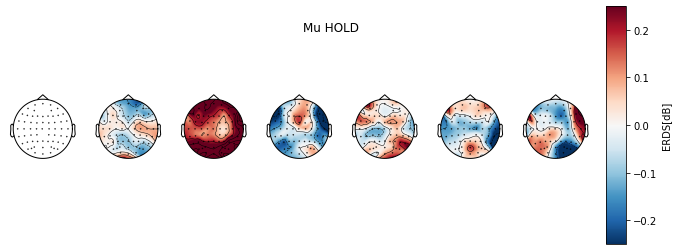

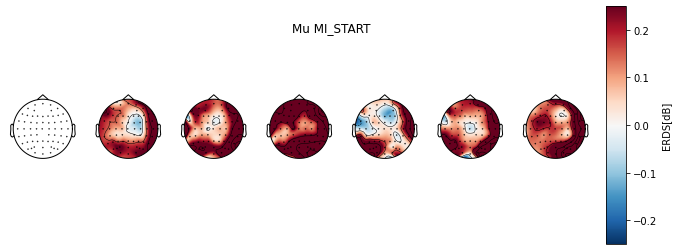

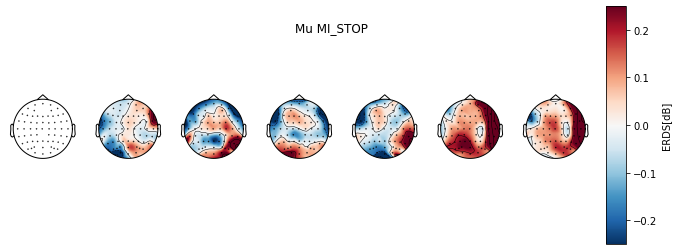

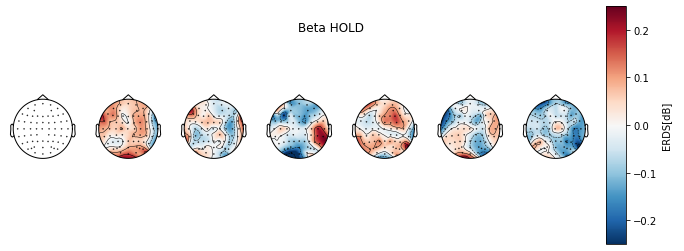

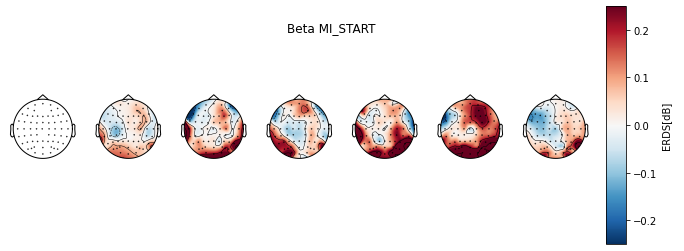

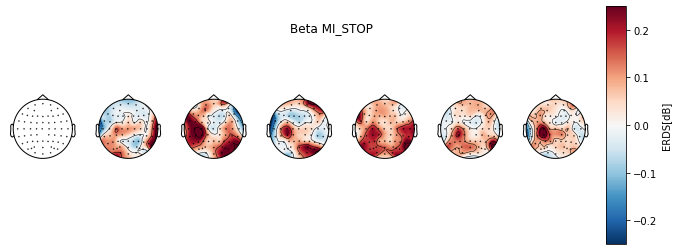

In [37]:
import seaborn as sns
import pandas as pd
from utils.utils_normalization import zscore_over_trials
from numpy import zeros, newaxis

baseline_event = {'HOLD':(-3,-1),'MI_START':(-3,-1),
                'MI_STOP':(-7,-5)}

fig = plt.figure(figsize=(20,8))
picks_respfiltered = raw_filter.ch_names.index("AUX3filter")
nbins = 7
bins = np.linspace(-np.pi, np.pi, nbins)

nBand = len(iter_freqs)
iplot = 0
df_events = dict()

timeInterval_event = {'HOLD':[-3,-1],'MI_START':[1,4],
                'MI_STOP':[1,3]}

scale = [-0.25,0.25]
my_cmap_r = reverse_colourmap(plt.cm.RdBu, name = 'RdBu')
my_cmap_r = center_cmap(my_cmap_r, scale[0], scale[1])  # zero maps to white
power_phase_av = dict()
for iBand,band_name in enumerate(epoch_bandpower):
    for iEvent,event_type in enumerate(listEventOfInterest):
        print(event_type)
        
        index_1 = np.where(epoch_bandpower[band_name].times == timeInterval_event[event_type][0])[0][0]
        index_2 = np.where(epoch_bandpower[band_name].times == timeInterval_event[event_type][1])[0][0]
        iplot +=1
        
        # phase respiration
        data_resp_event = np.squeeze(epochs_phase[event_type].get_data(picks=picks_respfiltered)).real
        data_resp_event = data_resp_event[:,index_1:index_2+1]
        ind = np.digitize(data_resp_event, bins)
   
        # baseline + bandpower
        data_mu = epoch_bandpower[band_name][event_type]._data
#         data_mu = zscore_over_trials(data_mu)
        data_mu = mne.baseline.rescale(data_mu, epoch_bandpower[band_name][event_type].times, 
                                       baseline=baseline_event[event_type])
        
        data_mu = data_mu[:,:,index_1:index_2+1]
       
        power_phase = np.zeros(np.shape(data_mu))
        power_phase_av_bins = []
        for iBin in range(nbins):
            for i in range(61):
                A = np.array(ind==iBin).astype(float)
                A[A==0] = np.nan
                power_phase[:,i,:] =  data_mu[:,i,:]*A  
            power_phase_av_bins.append(np.nanmean(np.nanmean(power_phase,axis=2),axis=0))
        
         # Visualization
        fig, axes = plt.subplots(1, nbins+1,figsize=(12, 4))
        for i,ax in enumerate(axes[:-1]):
                ax = mne.viz.plot_topomap(power_phase_av_bins [i],epoch_bandpower[band_name].info,axes=ax, 
                            cmap=my_cmap_r,
                            vmin=scale[0], vmax=scale[1],show = False)
        axes[-1].axis('off')
        title = band_name + " "+ event_type
        power_phase_av.update({title:power_phase_av_bins})
        divider = make_axes_locatable(axes[-1])
        cax = divider.append_axes('left', size='40%')
        cb = fig.colorbar(axes[0].images[-1], cax=cax, pad=0.05)
        cb.ax.set_ylabel('ERDS[dB]')
        fig.suptitle(title,y=0.9)
        fig.show()        

# Saving Data


In [ ]:
saving_var('bandpower_phase_coupling_new_ICA',folderSubject,power_phase_av)